In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import random


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 2

captions_path = 'text_c10'
img_name_path = 'images.txt'
data_path = 'images/'

word_counts = defaultdict(float)
print(word_counts)

defaultdict(<class 'float'>, {})


In [2]:
name_id = open(img_name_path).read().splitlines()
name2id_train = {}
id2name_train = {}
for index, img in enumerate (name_id):
        name2id_train[img.split(' ')[1]] = img.split(' ')[0]
        id2name_train[img.split(' ')[0]] = img.split(' ')[1]

id2caption_train = {}

for name in name2id_train:
    txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
    txt_path = os.path.join(captions_path, txt_name)
    idx = name2id_train[name]
    id2caption_train[idx] = open(txt_path,  encoding='utf-8').read().splitlines()

In [4]:
all_captions =[]
from nltk.tokenize import RegexpTokenizer
for i, captions in enumerate(id2caption_train.values()):
    for cap in captions:
        if len(cap) == 0:
            continue
        cap = cap.replace(u"\ufffd\ufffd", u" ")

        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(cap.lower())

        if len(tokens) == 0:
            print('cap', cap)
            continue

        tokens_new = []
        for t in tokens:
            t = t.encode('ascii', 'ignore').decode('ascii')
            if len(t) > 0:
                tokens_new.append(t)
        all_captions.append(tokens_new)
        
word_counts = defaultdict(float)
captions = all_captions
for sent in captions:
    for word in sent:
        word_counts[word] += 1

vocab = [w for w in word_counts if word_counts[w] >= 0]

ixtoword = {}
ixtoword[0] = '<end>'
wordtoix = {}
wordtoix['<end>'] = 0
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [5]:
print(len(wordtoix))

5450


In [17]:
class DataLoader:
    def __init__(self):
        self.device = device
        self.batch_size = batch_size
        self.data_path = data_path
        name_id = open(img_name_path).read().splitlines()
        
        random.shuffle(name_id)
        
        name2id_train = {}
        id2name_train = {}
        name2id_test = {}
        id2name_test = {}
        for index, img in enumerate (name_id):
            if(len(name2id_train) < 9430):
                name2id_train[img.split(' ')[1]] = img.split(' ')[0]
                id2name_train[img.split(' ')[0]] = img.split(' ')[1]
            else:
                name2id_test[img.split(' ')[1]] = img.split(' ')[0]
                id2name_test[img.split(' ')[0]] = img.split(' ')[1]
       
        id2caption_train = {}
        id2caption_test = {}
        
        for name in name2id_train:
            txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
            txt_path = os.path.join(captions_path, txt_name)
            idx = name2id_train[name]
            id2caption_train[idx] = open(txt_path,  encoding='utf-8').read().splitlines()
        
        for name in name2id_test:
            txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
            txt_path = os.path.join(captions_path, txt_name)
            idx = name2id_test[name]
            id2caption_test[idx] = open(txt_path,  encoding='utf-8').read().splitlines()
        
        self.name2id_train = name2id_train
        self.id2name_train = id2name_train
        self.name2id_test = name2id_test
        self.id2name_test = id2name_test
        
        self.id2caption_train = id2caption_train
        self.id2caption_test = id2caption_test
        
        self.data_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize([256, 256]),
#                 torchvision.transforms.CenterCrop(256),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

#         self.text_transforms = torchvision.transforms.Compose([
# #             torchvision.transforms.ToTensor()
#             #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])
        
    def load_img(self, image_name):
        image = Image.open(image_name)
        image = self.data_transforms(image).float()
        image = torch.autograd.Variable(image, requires_grad=False)
        image = image.unsqueeze(0)
        return image[0].to(device)
    
    def imshow(self, img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.cpu().detach().numpy()
        plt.figure(figsize = (5,5))
        plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')
        
    def padding(self, unpadded):
        l = []
        for i in unpadded:
            for j in i:
                l.append([len(j)])
        lens = np.array(l)   
        mask = lens[:,None] > np.arange(lens.max())
        out = np.full(mask.shape,0)
        out[mask] = np.concatenate(np.concatenate(unpadded))
        out = out.reshape(len(unpadded),10,-1)
        return torch.Tensor(out)
    
    def get_data(self, train=True):
        if train == True:
            images = self.id2name_train
            lb = self.id2caption_train
        else:
            images = self.test_id2name_test
            lb = self.id2caption_test
        while True:
            ix = np.random.choice(np.arange(len(images)), self.batch_size)
            x = []
            z = []
            for i in ix:
                print(images[str(i)])
                print(lb[str(i)])
                x.append(self.load_img(self.data_path + images[str(i)]))
                            
                tmp = []
                for cap in lb[str(i)]:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace(u"\ufffd\ufffd", u" ")
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())

                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    tmp.append(tokens_new)

                train_captions_new = []
                for t in tmp:
                    rev = []
                    for w in t:
                        if w in wordtoix:
                            rev.append(wordtoix[w])
                    train_captions_new.append(rev)
                z.append(train_captions_new)
            yield torch.stack(x), self.padding(z)
            
loader = DataLoader()
x, y = next(loader.get_data(True))

015.Lazuli_Bunting/Lazuli_Bunting_0027_14895.jpg
['the bird has a blue crown and a small black bill.', 'a small colorful bird with blue and grey covering its nape and back, blue feathers with one white wing bar, and a reddish brown breast.', 'this bird has a white belly, brown breast and a blue head and back.', 'this bird has a tan breast, a white belly and blue over the rest of its body.', 'this bird has a white belly, brown breast and a blue wing and head.', 'this bird is blue with black and white and has a very short beak.', 'this bird has wings that are blue and has a white belly', 'this bird has wings that are blue and has a white belly', 'this bird has a white and tan belly and a blue crown and dark blue grey secondaries and primaries.', 'this colorful bird has a short bill, blue head,blue on its back and tail feathers, grayish blue on the wings with a peach colored breast and belly.']
084.Red_legged_Kittiwake/Red_Legged_Kittiwake_0049_795440.jpg
['this bird is all white except f

torch.Size([2, 3, 256, 256])
torch.Size([2, 10, 28])


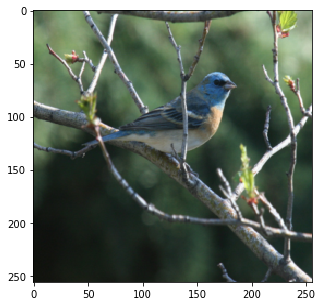

In [18]:
print(x.shape)
loader.imshow(x[0])
print(y.shape)